In [47]:
import pandas as pd 
import os
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from subprocess import check_output
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMAResults
from pandas import datetime
from sklearn.metrics import mean_squared_error
df = pd.read_csv("../Resources/btcjoin.csv", index_col='date', parse_dates=['date'])
df = df.drop(columns=['volume','change', 'low', 'high', 'open','value','address','mined'])
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
print(df.tail())

C:\Users\16474\AppData\Local\Temp\ipykernel_17260\1075707939.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


              price
date               
2022-10-21  19162.6
2022-10-22  19204.8
2022-10-23  19571.2
2022-10-24  19331.5
2022-10-25  20073.1


In [48]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.price.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.769203
p-value: 0.395855


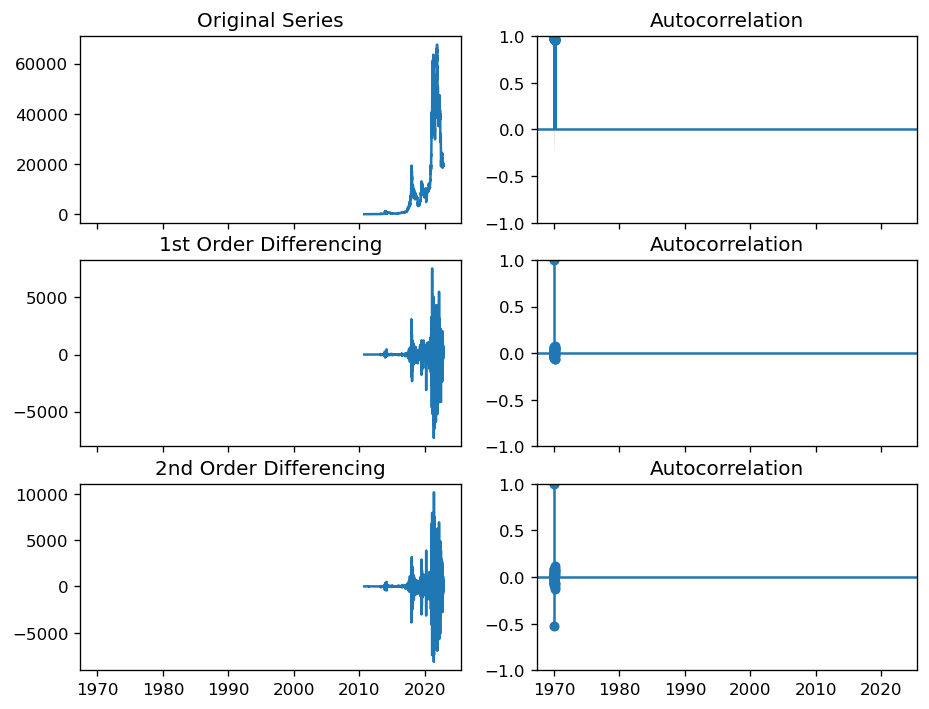

In [49]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.price); axes[0, 0].set_title('Original Series')
plot_acf(df.price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.price.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.price.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.price.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.price.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [50]:
from pmdarima.arima.utils import ndiffs
y = df.price

## Adf Test
ndiffs(y, test='adf')  # 2

# KPSS test
ndiffs(y, test='kpss')  # 0

# PP test:
ndiffs(y, test='pp')  # 2

1

c:\Users\16474\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


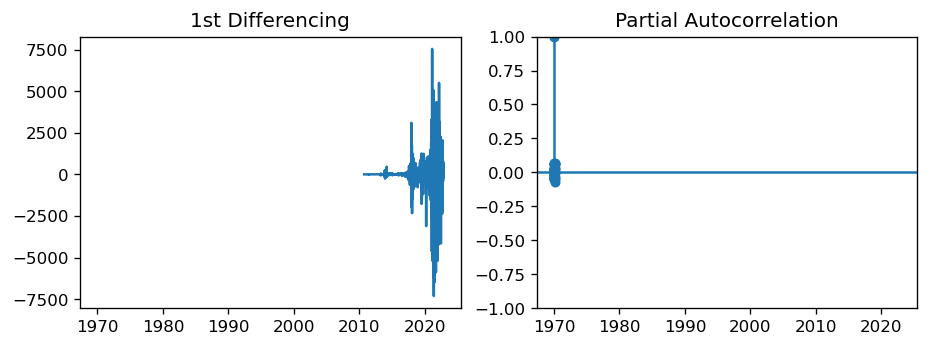

In [51]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.price.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.price.diff().dropna(), ax=axes[1])

plt.show()

In [52]:
#https://stackoverflow.com/questions/70223523/statsmodel-typeerror-fit-got-an-unexpected-keyword-argument-disp
from statsmodels.tsa.arima.model import ARIMA

import statsmodels.api as smapi

model = smapi.tsa.arima.ARIMA(df, order=(1,1,2))

result = model.fit()
print(result.summary())

c:\Users\16474\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\16474\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\16474\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 4386
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -34707.176
Date:                Mon, 21 Nov 2022   AIC                          69422.352
Time:                        20:05:46   BIC                          69447.896
Sample:                             0   HQIC                         69431.364
                               - 4386                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9647      0.014     71.323      0.000       0.938       0.991
ma.L1         -1.0018      0.014    -69.672      0.000      -1.030      -0.974
ma.L2          0.0441      0.007      6.787      0.0

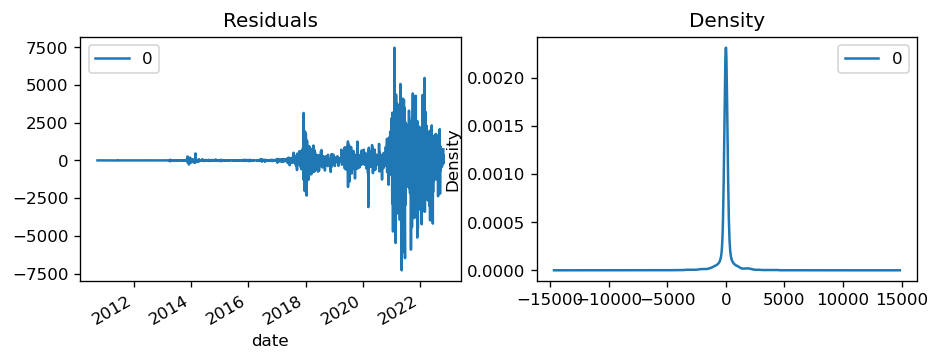

In [53]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

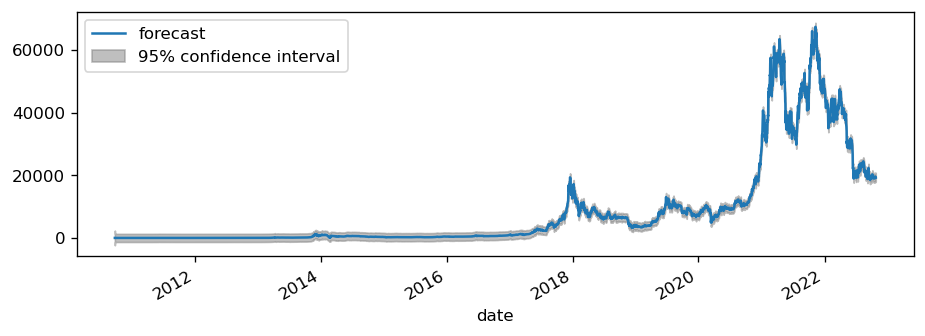

In [54]:
plot_predict(result, dynamic=False)
plt.show()

In [59]:
from statsmodels.tsa.stattools import acf
df['price'] = df['price'].astype(str)
# Create Training and Test
train = df.price[:85]
test = df.price[85:]

In [60]:
train

date
2010-09-25    0.1
2010-09-26    0.1
2010-09-27    0.1
2010-09-28    0.1
2010-09-29    0.1
             ... 
2010-12-14    0.2
2010-12-15    0.2
2010-12-16    0.3
2010-12-17    0.2
2010-12-18    0.2
Name: price, Length: 85, dtype: object

In [61]:
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
# Build Model
# model = ARIMA(train, order=(3,2,1))  
# model = ARIMA(train, order=(1, 1, 1))  
# fitted = model.fit(disp=-1)  

model = smapi.tsa.arima.ARIMA(train, order=(1,1,2))

fitted = model.fit()


# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\16474\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\16474\AppData\Local\Temp\ipykernel_17260\2676406025.py", line 6, in <cell line: 6>
    model = smapi.tsa.arima.ARIMA(train, order=(1,1,2))
  File "c:\Users\16474\anaconda3\lib\site-packages\statsmodels\tsa\arima\model.py", line 153, in __init__
    self._spec_arima = SARIMAXSpecification(
  File "c:\Users\16474\anaconda3\lib\site-packages\statsmodels\tsa\arima\specification.py", line 446, in __init__
    self._model = TimeSeriesModel(endog, exog=exog, dates=dates, freq=freq,
  File "c:\Users\16474\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py", line 468, in __init__
    super().__init__(endog, exog, missing=missing, **kwargs)
  File "c:\Users\16474\anaconda3\lib\site-packages\statsmodels\base\model.py", line 267, in __init__
    super().__init__(endog, exog, 